In [2]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf

In [0]:
from skimage.color import gray2rgb, rgb2gray, label2rgb

In [5]:
from keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step


In [6]:
train_x.shape

(60000, 28, 28)

In [0]:
image = gray2rgb(train_x[0].reshape(28,28))

In [8]:
train_y.shape

(60000,)

In [0]:
import matplotlib.pyplot as plt
import numpy as np

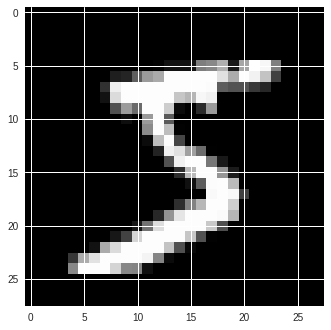

In [10]:
plt.imshow(image)

In [0]:
train_y_new = []

for i in train_y:
  l =[0]*10
  l[i] = 1
  train_y_new.append(l)

In [0]:
train_y = np.array(train_y_new)

In [13]:
train_y.shape

(60000, 10)

In [0]:
test_y_new = []

for i in test_y:
  l =[0]*10
  l[i] = 1
  test_y_new.append(l)

In [0]:
test_y = np.array(test_y_new)

In [16]:
test_y.shape

(10000, 10)

In [0]:
train_x = np.stack([gray2rgb(iimg) for iimg in train_x],0)
test_x = np.stack([gray2rgb(iimg) for iimg in test_x],0)

In [18]:
train_x.shape

(60000, 28, 28, 3)

In [0]:
batch_size = 128
filter_size = 3

In [0]:
x = tf.placeholder(tf.float32,(None, 28,28,3))

In [0]:
y = tf.placeholder(tf.float32,(None,10))
result = tf.Variable(tf.random_normal([10]))

In [0]:
#Let our model have three Convolutional Layers

#The first layer will have 16 3X3 filters.
#The second layer will have 32 3X3 filters.
#The third layer will have 64 3X3 filters.

#Each layer will have a corresponding bias term as well.

#At the end of each layer we will have a max pooling layer performing the pooling operation
#The pool will be done by a 2X2 filter.

#We will then flatten the output from the last convolution layer to feed it as the input to the fully connected layer.

In [0]:
#conv layer 1 : input image of dimension 28 X 28 X 3.
#The third dimension of the image is the same to be used for the third dimension of the weights
#The conv layer 1 gives out 16 activation maps.
conv1_weight = tf.Variable(tf.truncated_normal([filter_size,filter_size,3,16],stddev=0.1))
conv1_bias = tf.Variable(tf.truncated_normal([16],stddev = 0.1))

#conv layer 2 : input is 16 activation maps from conv layer 1.
#The conv layer 2 gives out 32 activation maps.
conv2_weight = tf.Variable(tf.truncated_normal([filter_size,filter_size,16,32],stddev = 0.1))
conv2_bias = tf.Variable(tf.truncated_normal([32],stddev = 0.1))

#conv layer 3 : input is 32 activation maps from conv layer 2.
#The conv layer 3 gives out 64 activation maps.
conv3_weight = tf.Variable(tf.truncated_normal([filter_size,filter_size,32,64],stddev = 0.1))
conv3_bias = tf.Variable(tf.truncated_normal([64],stddev=0.1))

In [0]:
#At the end of these convolution layers we have 4 X 4 X 1 activation maps and 64 of those.
#We need to flatten these

flatten_weight = tf.Variable(tf.truncated_normal([4*4*64,64],stddev =0.1))
flatten_bias = tf.Variable(tf.truncated_normal([64],stddev = 0.1))

In [0]:
#Finally the output layer

output_weight = tf.Variable(tf.truncated_normal([64,10],stddev = 0.1))
output_bias = tf.Variable(tf.truncated_normal([10],stddev = 0.1))

In [0]:
#Now we need to define a wrapper around the tensoflow conv2d function to return the conv layer output
#It takes 3 arguments 
#    1.The input -> x
#    2.The weights -> w
#    3.The bias -> b
#We use Relu as the activation function

#We take the stride as 1
stride = 1

def convolution_2d(x, w, b):
  x = tf.nn.conv2d(x, w, strides=[1, stride, stride, 1], padding='SAME')
  
  z = tf.nn.bias_add(x,b)
  
  op = tf.nn.relu(z)
  
  return op

In [0]:
#Now we need to define a wrapper around the tensoflow maxpool2d function to return the pooled output
#It takes 2 arguments 
#    1.The input -> x
#    2.The kernel size -> k

#We take the kernel size as 2
kernel_size = 2

def maxpool_2d(x):
  op = tf.nn.max_pool(x, ksize = [1,kernel_size,kernel_size,1], strides = [1,kernel_size,kernel_size,1], padding = 'SAME')
  
  return op

In [0]:
#The function for the fully connected layer
#It takes 3 arguments 
#    1.The input -> x
#    2.The weights -> w
#    3.The bias -> b
#We use Relu as the activation function

def fully_connected_layer(x,w,b):
  z = tf.matmul(x,w)
  z = tf.add(z,b)
  
  op = tf.nn.relu(z)
  
  return op

In [0]:
#Output layer
#It takes 3 arguments 
#    1.The input -> x
#    2.The weights -> w
#    3.The bias -> b

def output_layer(x,w,b):
  z = tf.matmul(x,w)
  z = tf.add(z,b)
  return z


In [0]:
#Now that we have our wrappers ready, we need to create the model

def cnn_model(x):
  
  #creating the first layer
  conv1 = convolution_2d(x,conv1_weight,conv1_bias)
  conv1 = maxpool_2d(conv1)
  
  #creating the second layer
  conv2 = convolution_2d(conv1,conv2_weight,conv2_bias)
  conv2 = maxpool_2d(conv2)
  
  #creating the third layer
  conv3 = convolution_2d(conv2,conv3_weight,conv3_bias)
  conv3 = maxpool_2d(conv3)
  
  #we need to reshape the conv3 output to fit the fully connected layer
  shape_fully_connected = flatten_weight.get_shape().as_list()[0]
  
  fully_connected = tf.reshape(conv3,[-1,shape_fully_connected])
  fully_connected_output = fully_connected_layer(fully_connected, flatten_weight, flatten_bias)
  
  #Output Layer for the class prediction
  output = output_layer(fully_connected_output, output_weight, output_bias)
  
  return output

In [31]:
#now we need to write the loss function for the model

#learning rate
learning_rate = 0.001

prediction = cnn_model(x)

#using cross entropy loss and softmax activation
cost_function = tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y)

#take the mean of all the samples in the batch
cost = tf.reduce_mean(cost_function)

#Using Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
optimizer = optimizer.minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
#check for the correctness of the prediction

correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))

#calculate over the entire batch

accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [0]:
#initialize weights and biases

initializer = tf.global_variables_initializer()

In [34]:
train_x.shape

(60000, 28, 28, 3)

Text(0.5,1,'Output Class is : [0 0 0 0 1 0 0 0 0 0]')

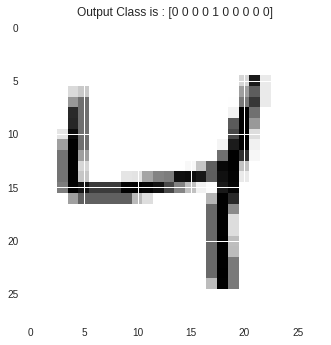

In [35]:
train1 = train_x[2]

train1.shape
train1 = rgb2gray(train1)
output_label_new  = train_y[2]
plt.imshow(train1)
plt.title("Output Class is : "+str(output_label_new))

In [0]:
number_of_epochs = 50
number_of_batches = len(train_x)//batch_size

In [0]:
sess = tf.Session()

#initialize all the global variables
sess.run(initializer)

In [38]:
#creating the arrays to record the loss and accuracy
training_loss = []
training_accuracy = []

validation_losses = []
validation_accuracies = []

summary_writer = tf.summary.FileWriter('./Output', sess.graph)

#loop over all the epochs

for i in range(number_of_epochs):

  #for each batch
  train_loss = 0
  train_accuracy = 0
  for batch in range(number_of_batches):

    #need to obtain corresponding x and y for the batch from the train data

    lower_limit = batch*batch_size
    upper_limit = min((batch+1)*batch_size,len(train_x))

    batch_x = train_x[lower_limit:upper_limit]
    batch_y = train_y[lower_limit:upper_limit]

    #Run the optimizer and
    #Calculate the loss and the accuracy
    _, l_ ,acc_ = sess.run([optimizer, cost, accuracy],feed_dict={x: batch_x, y: batch_y})
    train_loss += l_
    train_accuracy += acc_

  train_loss /= number_of_batches
  train_accuracy /= number_of_batches


  #For the validation data
  validation_loss, validation_accuracy = sess.run([cost,accuracy],feed_dict={x: test_x, y: test_y})

  print("Epoch: ",str(i)," : TrainLoss: ",str(train_loss)," TrainAccuracy: ",str(train_accuracy), " ValidLoss: ",str(validation_loss)," ValidAccuracy : ",str(validation_accuracy))


  training_loss.append(train_loss)
  training_accuracy.append(train_accuracy)

  validation_losses.append(validation_loss)
  validation_accuracies.append(validation_accuracy)

  summary_writer.close() 

Epoch:  0  : TrainLoss:  1.5315427408965592  TrainAccuracy:  0.8665865384615384  ValidLoss:  0.18677095  ValidAccuracy :  0.9491
Epoch:  1  : TrainLoss:  0.13893339254258552  TrainAccuracy:  0.9611211271367521  ValidLoss:  0.11416033  ValidAccuracy :  0.9685
Epoch:  2  : TrainLoss:  0.0787082099574409  TrainAccuracy:  0.9767127403846154  ValidLoss:  0.0963617  ValidAccuracy :  0.9729
Epoch:  3  : TrainLoss:  0.05452628920509472  TrainAccuracy:  0.9837573450854701  ValidLoss:  0.08236299  ValidAccuracy :  0.9771
Epoch:  4  : TrainLoss:  0.04286856503404901  TrainAccuracy:  0.9862947382478633  ValidLoss:  0.08049003  ValidAccuracy :  0.9775
Epoch:  5  : TrainLoss:  0.03348948672771032  TrainAccuracy:  0.9892494658119658  ValidLoss:  0.08104488  ValidAccuracy :  0.9779
Epoch:  6  : TrainLoss:  0.03391075185851135  TrainAccuracy:  0.9891993856837606  ValidLoss:  0.07831516  ValidAccuracy :  0.9804
Epoch:  7  : TrainLoss:  0.02863546455149549  TrainAccuracy:  0.9905515491452992  ValidLoss: 

In [39]:
test_x.shape

(10000, 28, 28, 3)

In [40]:
#Make predictions
for i in range(100,150):
  img = np.reshape(rgb2gray(test_x[i]), (28,28))
  # plt.imshow(img)
  img = np.reshape(img, (1,28,28,1))
  result = cnn_model(test_x[i].reshape(-1,28,28,3).astype(np.float32))

  pred = np.array(sess.run(tf.nn.softmax(result))[0])
  pred = np.argmax(pred)
  output = np.argmax(test_y[i])
  print("Predicted: {}, Output: {}".format(pred, output))

Predicted: 6, Output: 6
Predicted: 0, Output: 0
Predicted: 5, Output: 5
Predicted: 4, Output: 4
Predicted: 9, Output: 9
Predicted: 9, Output: 9
Predicted: 2, Output: 2
Predicted: 1, Output: 1
Predicted: 9, Output: 9
Predicted: 4, Output: 4
Predicted: 8, Output: 8
Predicted: 7, Output: 7
Predicted: 3, Output: 3
Predicted: 9, Output: 9
Predicted: 7, Output: 7
Predicted: 4, Output: 4
Predicted: 4, Output: 4
Predicted: 4, Output: 4
Predicted: 9, Output: 9
Predicted: 2, Output: 2
Predicted: 5, Output: 5
Predicted: 4, Output: 4
Predicted: 7, Output: 7
Predicted: 6, Output: 6
Predicted: 7, Output: 7
Predicted: 9, Output: 9
Predicted: 0, Output: 0
Predicted: 5, Output: 5
Predicted: 8, Output: 8
Predicted: 5, Output: 5
Predicted: 6, Output: 6
Predicted: 6, Output: 6
Predicted: 5, Output: 5
Predicted: 7, Output: 7
Predicted: 8, Output: 8
Predicted: 1, Output: 1
Predicted: 0, Output: 0
Predicted: 1, Output: 1
Predicted: 6, Output: 6
Predicted: 4, Output: 4
Predicted: 6, Output: 6
Predicted: 7, Ou

In [0]:
#Calculating the Metrics for the Model

In [0]:
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0

In [0]:
actual_values = []
predicted_values = []

In [0]:
i = 0
#Make predictions
test_set = test_x[0:100]

for test_image in test_set:
  img = np.reshape(rgb2gray(test_image), (28,28))
  # plt.imshow(img)
  img = np.reshape(img, (1,28,28,1))
  result = cnn_model(test_image.reshape(-1,28,28,3).astype(np.float32))
  pred = np.array(sess.run(tf.nn.softmax(result))[0])
  pred = np.argmax(pred)
  output = np.argmax(test_y[i])
  i+=1
  actual_values.append(output)
  predicted_values.append(pred)
  print("Predicted: {}, Output: {}".format(pred, output))

In [200]:
np.array(actual_values).shape

(100,)

In [201]:
np.array(predicted_values).shape

(100,)

In [202]:
number_correct = 0
for i in range(len(predicted_values)):
  if(predicted_values[i]==actual_values[i]):
    number_correct +=1
print("Accurcay is : ",number_correct/len(predicted_values))

Accurcay is :  0.99


In [0]:
from sklearn.metrics import f1_score

In [205]:
f1score = f1_score(actual_values,predicted_values,average='weighted')

print("F1 Score is : ",f1score)

F1 Score is :  0.9899231950844853


In [0]:
from sklearn.metrics import recall_score

In [209]:
recall = recall_score(actual_values,predicted_values,average = 'weighted')

print("Recall Score is : ",recall)

Recall Score is :  0.99


In [0]:
from sklearn.metrics import precision_score

In [211]:
precision = precision_score(actual_values,predicted_values,average = 'weighted')

print("Precision Score is : ",precision)

Precision Score is :  0.990625


In [41]:
!pip install lime

    100% |████████████████████████████████| 276kB 7.5MB/s 
  Running setup.py bdist_wheel for lime ... - \ done
  Stored in directory: /root/.cache/pip/wheels/48/13/7c/20792e4efe5fd04237c0ac92bc8551acfe36392e09953ac8ea
Successfully built lime


In [0]:
import lime
from lime import lime_image

In [0]:
def prediction_function(x):
  result = cnn_model(x.reshape(-1,28,28,3).astype(np.float32))
  return sess.run(tf.nn.softmax(result))

In [0]:
explainer = lime_image.LimeImageExplainer()

In [121]:
test_sample = test_x[215]
test_sample_for_model = np.reshape(rgb2gray(test_sample),(-1,28,28,1))
test_sample = np.reshape(test_sample_for_model,(28,28))
print(test_sample.shape)

(28, 28)


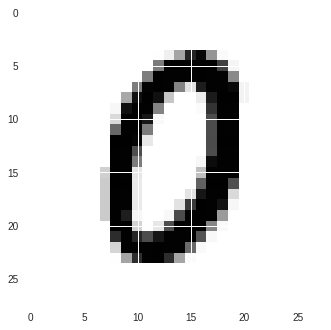

In [122]:
plt.imshow(test_sample)

In [0]:
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [0]:
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [0]:
explanation = explainer.explain_instance(test_x[0], 
                                         classifier_fn = prediction_function, 
                                         top_labels=10, hide_color=0, num_samples=100, segmentation_fn=segmenter)

In [126]:
sample_test_input = test_x[0]
sample_test_input.shape

(28, 28, 3)

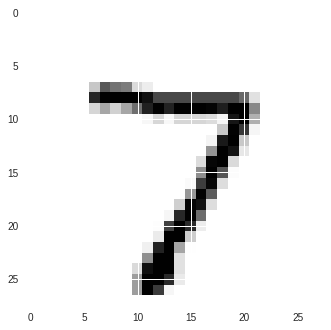

In [127]:
plt.imshow(np.reshape(rgb2gray(sample_test_input),(28,28)))

In [128]:
output = np.argmax(test_y[0])
output

7

Text(0.5,1,'Positive Regions for 7')

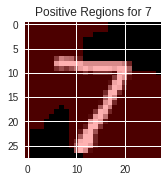

In [129]:
temp, mask = explanation.get_image_and_mask(output, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig= plt.figure()
(ax1) = fig.add_subplot(2,1,1)
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(output))

In [0]:
fig.savefig("sample_input_explanation.jpeg")

Text(0.5,1,'Positive and Negative Regions for 7')

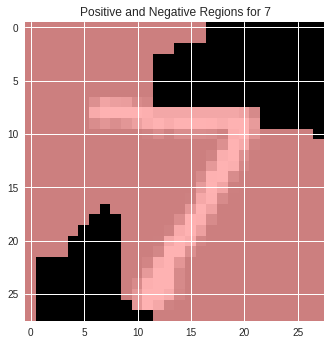

In [131]:
temp1, mask1 = explanation.get_image_and_mask(output, positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
(ax2) = plt.subplot()
ax2.imshow(label2rgb(mask1,temp1, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive and Negative Regions for {}'.format(output))

In [0]:
def add_noise(image):
  row,col,ch = image.shape
  s_vs_p = 0.5
  amount = 0.01
  out = np.copy(image)
  # Salt mode
  num_salt = np.ceil(amount * image.size * s_vs_p)
  coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
  out[coords] = 1

  # Pepper mode
  num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
  coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
  out[coords] = 0
  return out

In [0]:
noisy_input = add_noise(sample_test_input)

In [134]:
noisy_input.shape

(28, 28, 3)

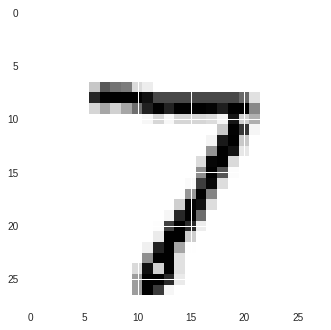

In [135]:
plt.imshow(np.reshape(rgb2gray(noisy_input),(28,28)))

In [0]:
from skimage.measure import structural_similarity as ssim
import cv2

In [0]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

def compare_images(imageA, imageB, title):
  # compute the mean squared error and structural similarity
  # index for the images
  m = mse(imageA, imageB)
  s = ssim(imageA, imageB,multichannel=True)

  # setup the figure
  fig = plt.figure(title)
  plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))

  # show first image
  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(imageA, cmap = plt.cm.gray)
  plt.axis("off")

  # show the second image
  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(imageB, cmap = plt.cm.gray)
  plt.axis("off")

  # show the images
  plt.show() 
  return m,s

/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:234: skimage_deprecation: Function ``structural_similarity`` is deprecated and will be removed in version 0.14. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,


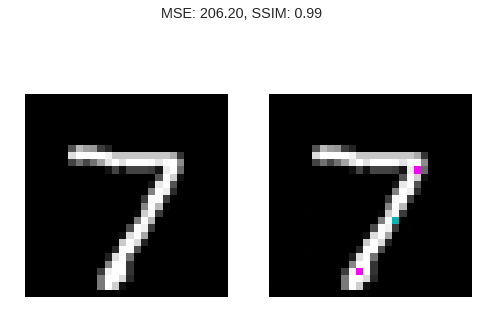

In [150]:
mse1,s1 = compare_images(sample_test_input,noisy_input,"Image Difference")

In [0]:
explanation = explainer.explain_instance(noisy_input, 
                                         classifier_fn = prediction_function, 
                                         top_labels=10, hide_color=0, num_samples=100, segmentation_fn=segmenter)

Text(0.5,1,'Positive Regions for 7')

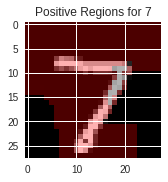

In [152]:
temp, mask = explanation.get_image_and_mask(output, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig= plt.figure()
(ax1) = fig.add_subplot(2,1,1)
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(output))

In [0]:
fig.savefig("noisy_input_explanation.jpeg")

In [0]:
img = cv2.imread('noisy_input_explanation.jpeg')

In [155]:
img.shape

(396, 576, 3)

In [0]:
img2 = cv2.imread('sample_input_explanation.jpeg')

In [157]:
img2.shape

(396, 576, 3)

/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:234: skimage_deprecation: Function ``structural_similarity`` is deprecated and will be removed in version 0.14. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,


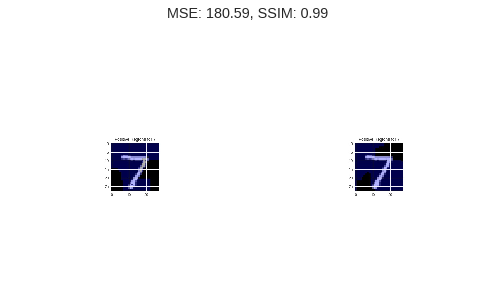

In [158]:
mse2,s2= compare_images(img,img2,"Explanation Difference")

In [0]:
#stability score for the current image
# stability = change in the explanation / change in the input
stability = mse2/mse1

In [160]:
stability

0.875786165658815

In [0]:
#To find the average stability of the model
#we can run over all the test images